In [86]:
# Standard imports
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specific imports
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_regression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Local imports
from src.utils import eda, plot, evaluation


warnings.filterwarnings("ignore")

- *Preprocessed data*

In [ ]:
# Read preprocessed data from file (parquet or csv file)
# Parquet file is preferable as it keeps the original data types
# and it is way more optmized than a csv file
df_preprocessed = pd.read_csv(r"data\preprocessed_data.csv")

# Check data information
print(df_preprocessed.info())

# Split numerical and categorical features
categorical_features = ["season", "holiday", "workingday"]
numerical_features = df_preprocessed.drop(columns=categorical_features + ["count"]).columns

# Display data
df_preprocessed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17212 entries, 0 to 17211
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   season                    17212 non-null  object 
 1   holiday                   17212 non-null  bool   
 2   workingday                17212 non-null  bool   
 3   hour_sin                  17212 non-null  float64
 4   hour_cos                  17212 non-null  float64
 5   weekday_sin               17212 non-null  float64
 6   weekday_cos               17212 non-null  float64
 7   month_sin                 17212 non-null  float64
 8   month_cos                 17212 non-null  float64
 9   temp_lag_25h              17212 non-null  float64
 10  feel_temp_lag_25h         17212 non-null  float64
 11  humidity_lag_25h          17212 non-null  float64
 12  windspeed_lag_25h         17212 non-null  float64
 13  count_lag_25h             17212 non-null  float64
 14  temp_l

,season,holiday,workingday,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,temp_lag_25h,...,temp_roll_std_168h,feel_temp_roll_mean_168h,feel_temp_roll_std_168h,humidity_roll_mean_168h,humidity_roll_std_168h,windspeed_roll_mean_168h,windspeed_roll_std_168h,count_roll_mean_168h,count_roll_std_168h,count
0,spring,False,False,1.000000,6.123234e-17,-0.781831,0.62349,5.000000e-01,0.866025,9.02,...,3.758320,13.152465,4.347737,0.586597,0.177126,12.028128,7.556756,0.056636,0.051720,0.002047
1,spring,False,False,0.965926,-2.588190e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.762645,13.126146,4.351633,0.585764,0.176348,12.090615,7.493538,0.057119,0.051667,0.009212
2,spring,False,False,0.866025,-5.000000e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.765416,13.099861,4.359961,0.583750,0.175539,12.208656,7.435403,0.058328,0.053295,0.015353
3,spring,False,False,0.707107,-7.071068e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.768177,13.068299,4.372493,0.581458,0.174848,12.347542,7.392424,0.059053,0.053653,0.020471
4,spring,False,False,0.500000,-8.660254e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.769680,13.036736,4.379248,0.578819,0.175154,12.500339,7.362756,0.059408,0.053518,0.062436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17207,spring,False,True,-0.965926,2.588190e-01,0.781831,0.62349,-2.449294e-16,1.000000,9.84,...,1.463892,12.331493,1.969584,0.685903,0.163598,16.035008,10.185871,0.068819,0.070051,0.121801
17208,spring,False,True,-0.866025,5.000000e-01,0.781831,0.62349,-2.449294e-16,1.000000,13.94,...,1.468558,12.315729,1.980343,0.682708,0.163289,16.125318,10.180694,0.069203,0.069924,0.091095
17209,spring,False,True,-0.707107,7.071068e-01,0.781831,0.62349,-2.449294e-16,1.000000,9.02,...,1.480957,12.305208,1.985408,0.679792,0.162590,16.139230,10.172251,0.069373,0.069841,0.092119
17210,spring,False,True,-0.500000,8.660254e-01,0.781831,0.62349,-2.449294e-16,1.000000,8.20,...,1.493166,12.284167,1.995305,0.677153,0.161582,16.187805,10.140161,0.069473,0.069784,0.062436


- *[Time Series cross-validation][]*

[Time Series cross-validation]: https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

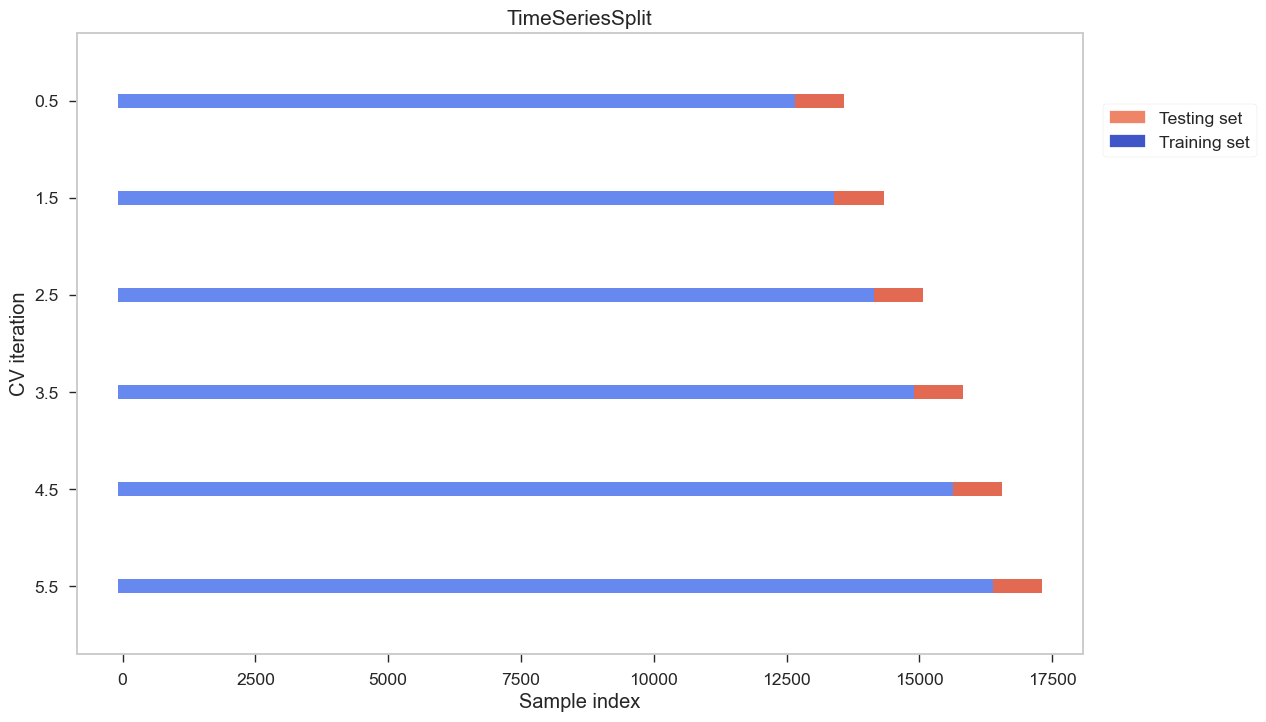

In [88]:
# Time Series cross-validator
# Provides train/test indices to split time series data samples 
# that are observed at fixed time intervals, in train/test sets.
X =  df_preprocessed.drop(columns=["count"])
y =  df_preprocessed["count"]

# Times Series Cross Validator Object
tss = TimeSeriesSplit(n_splits=6, test_size=24 * 31)

# Visualize split
eda.plot_cv_indices(X, y, tss, 6)

- *Evaluate Features*

<Axes: >

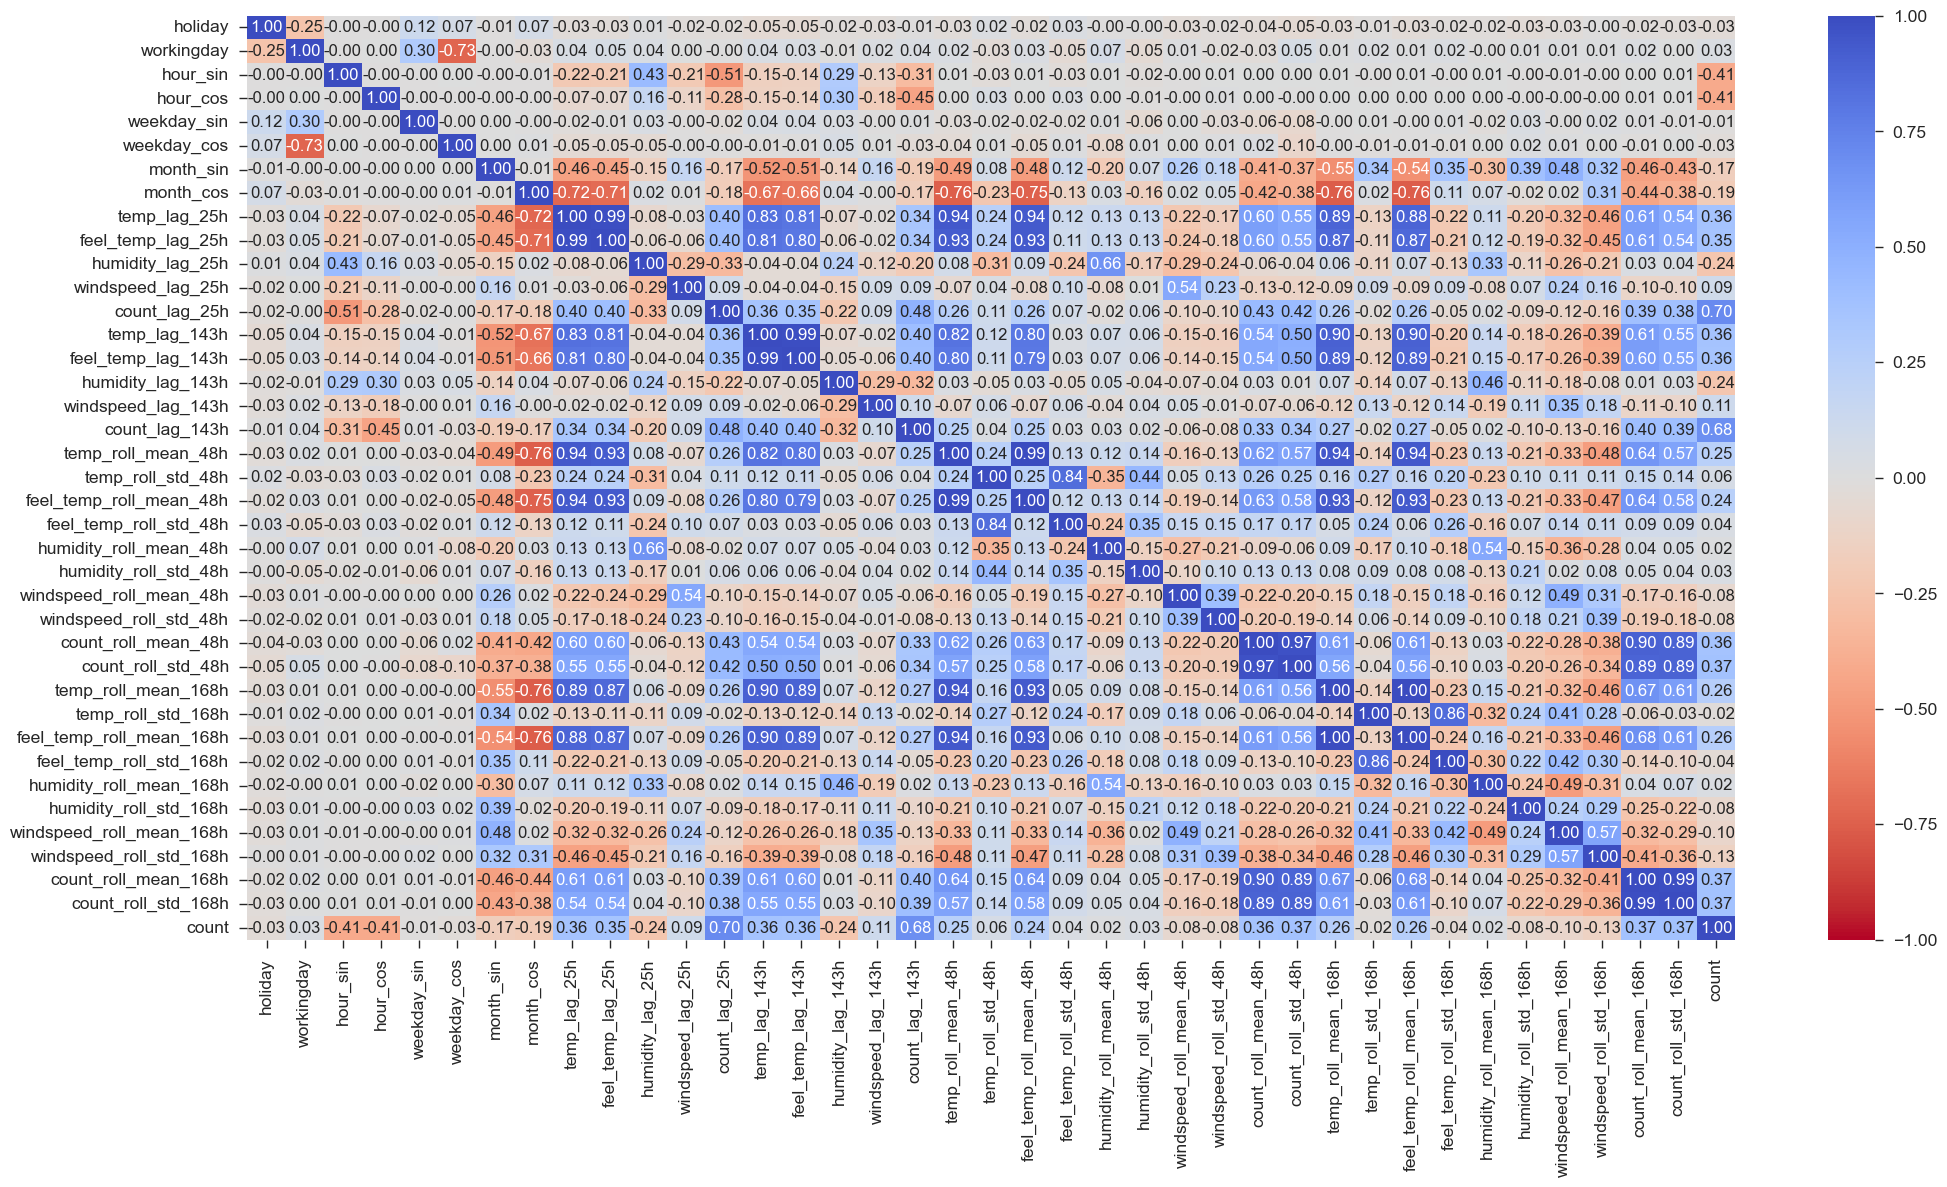

In [89]:
fig, ax = plt.subplots(figsize=(24, 12))

# Linear correlations (pearson)
sns.heatmap(
    df_preprocessed.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm_r",
    ax=ax,
    fmt=".2f",
    annot_kws={"size": 12}
)

Features selected (50 %) :

         Index(['hour_sin', 'hour_cos', 'temp_lag_25h', 'feel_temp_lag_25h',
       'humidity_lag_25h', 'count_lag_25h', 'temp_lag_143h',
       'feel_temp_lag_143h', 'humidity_lag_143h', 'count_lag_143h',
       'temp_roll_mean_48h', 'feel_temp_roll_mean_48h', 'count_roll_mean_48h',
       'count_roll_std_48h', 'temp_roll_mean_168h', 'feel_temp_roll_mean_168h',
       'count_roll_mean_168h', 'count_roll_std_168h'],
      dtype='object')


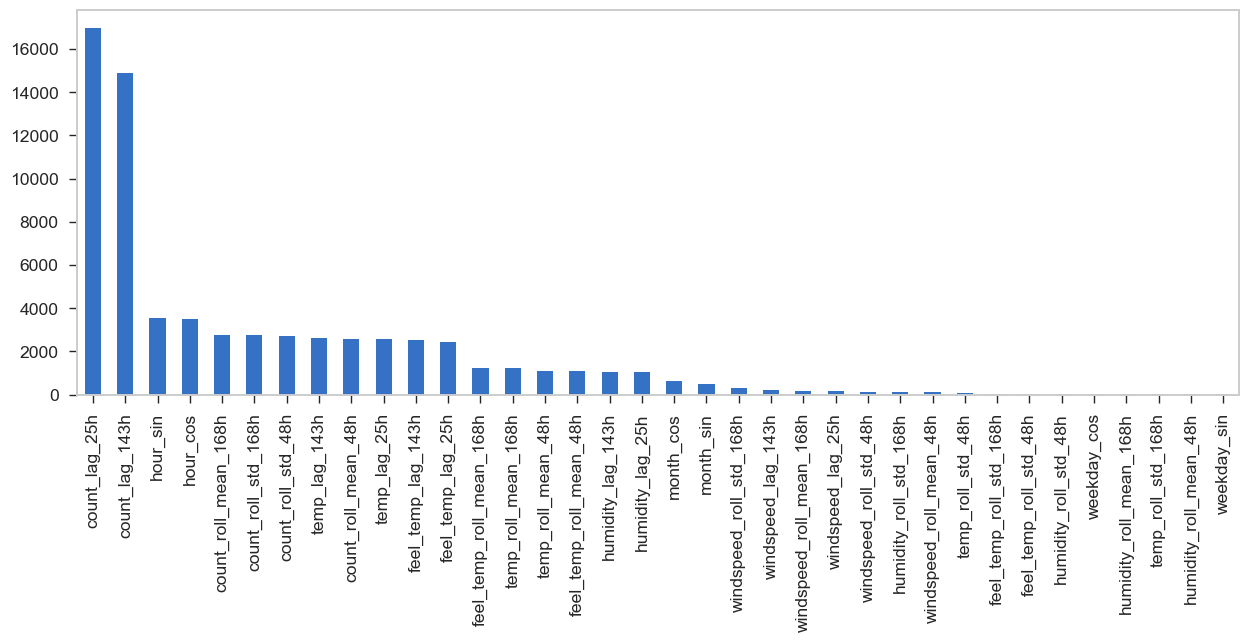

In [90]:
# Linear features importance
eda.feature_selection(X[numerical_features], y, percentile=50)

Features selected (10 %) :

         Index(['hour_sin', 'hour_cos', 'count_lag_25h', 'count_lag_143h'], dtype='object')


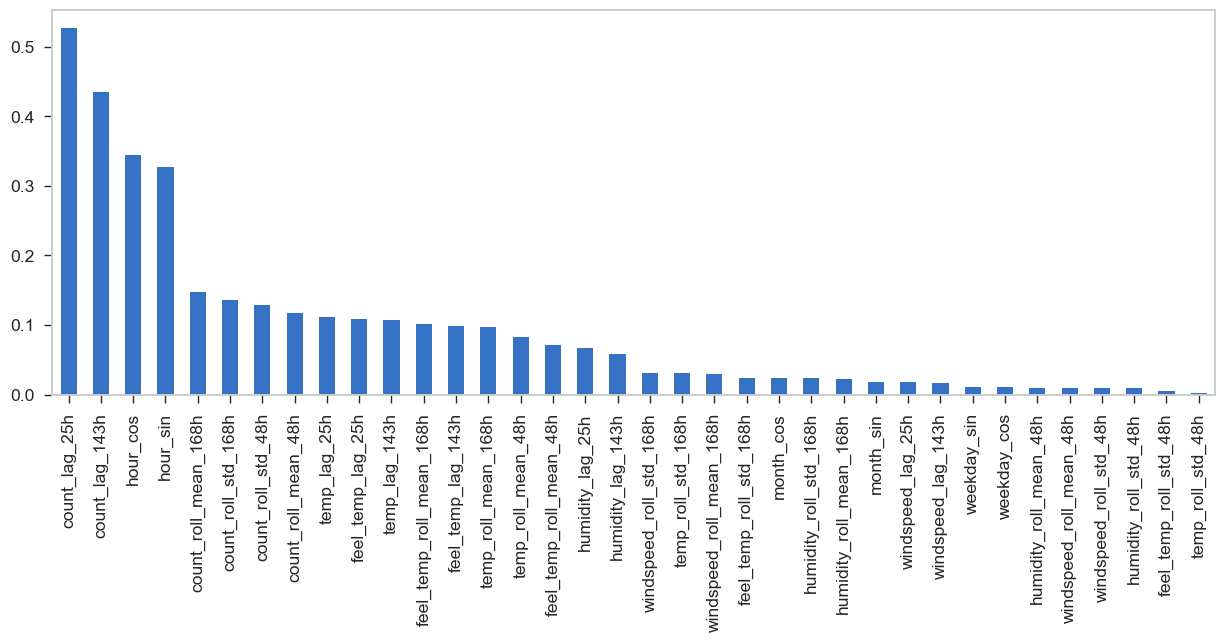

In [91]:
# Non-linear features importance
eda.feature_selection(X[numerical_features], y, percentile=10, method="non-linear")

- *Evaluate models*

In [92]:
# ----- Preprocessors -----
# 1) Preprocessor for models that require One-Hot or numeric-only input (linear, tree-with-OHE)
preprocessor_ohe = ColumnTransformer(transformers=[("num", StandardScaler(), numerical_features),
                                                   ("cat", OneHotEncoder(
                                                       handle_unknown="ignore", sparse_output=False), categorical_features)
                                                   ])

# 2) Preprocessor for models that accept integer-encoded categories (HistGradientBoosting)
#    We encode categories as integer labels (OrdinalEncoder), and scale numerics.
#    HistGB works well when categories are integer-coded, and numerics are scaled.
preprocessor_hgb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value",
                           unknown_value=-1),
            categorical_features,
        ),
    ],
    remainder="drop",
)

# 3) Preprocessor for neural nets (min-max scaling often helps activations)
preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="drop",
)

In [93]:
# ----- Estimator Pipelines -----
model_configs = {
    # Linear models (explicit feature selection can help reduce collinearity / noise)
    "RIDGE": Pipeline([("preproc", preprocessor_ohe), ("feat_sel", "passthrough"), ("reg", RidgeCV(cv=tss, scoring="neg_mean_squared_error"))]),
    "LASSO": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", SelectPercentile(score_func=f_regression, percentile=60)),
            ("reg", LassoCV(random_state=42, max_iter=10_000, cv=tss)),
        ]
    ),
    "ENET": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", SelectPercentile(score_func=f_regression, percentile=60)),
            (
                "reg",
                ElasticNetCV(
                    cv=tss, random_state=42, l1_ratio=[0.1, 0.5, 0.9], max_iter=10_000
                ),
            ),
        ]
    ),
    # Neural networks (benefit from reduced feature space)
    "NN": Pipeline(
        [
            ("preproc", preprocessor_nn),
            # ("feat_sel", ),
            (
                "reg",
                MLPRegressor(
                    random_state=42,
                    solver="adam",
                    hidden_layer_sizes=(30, 15),
                    activation="relu",
                    learning_rate_init=1e-3,
                    early_stopping=True,
                    validation_fraction=0.1,
                    alpha=1e-4,
                    max_iter=2000,
                    tol=1e-4,
                ),
            ),
        ]
    ),
    # Tree ensembles
    "RF": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                RandomForestRegressor(
                    random_state=42,
                    n_estimators=300,
                    max_depth=10,
                    max_features="sqrt",
                    # n_jobs=-1,
                ),
            ),
        ]
    ),
    "XG": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                XGBRegressor(
                    random_state=42,
                    n_estimators=500,
                    learning_rate=0.05,
                    max_depth=4,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    # n_jobs=-1,
                    verbosity=0,
                ),
            ),
        ]
    ),
    "LGBM": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                LGBMRegressor(
                    random_state=42,
                    n_estimators=1000,
                    learning_rate=0.05,
                    num_leaves=31,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    # n_jobs=-1,
                    verbosity=-1,
                ),
            ),
        ]
    ),
    # HistGB (native categorical support, skip explicit FS)
    "HGB": Pipeline(
        [
            ("preproc", preprocessor_hgb),
            # ("feat_sel", ),
            (
                "reg",
                HistGradientBoostingRegressor(
                    random_state=42, max_iter=1000, max_depth=10, learning_rate=0.05
                ),
            ),
        ]
    ),
}
# Convert config to list for your loop
models = list(model_configs.items())

RIDGE: -0.093172 (0.008721)
LASSO: -0.092691 (0.008623)
ENET: -0.092693 (0.008624)
NN: -0.063116 (0.006311)
RF: -0.076823 (0.007322)
XG: -0.062710 (0.004100)
LGBM: -0.058437 (0.004295)
HGB: -0.058410 (0.004338)


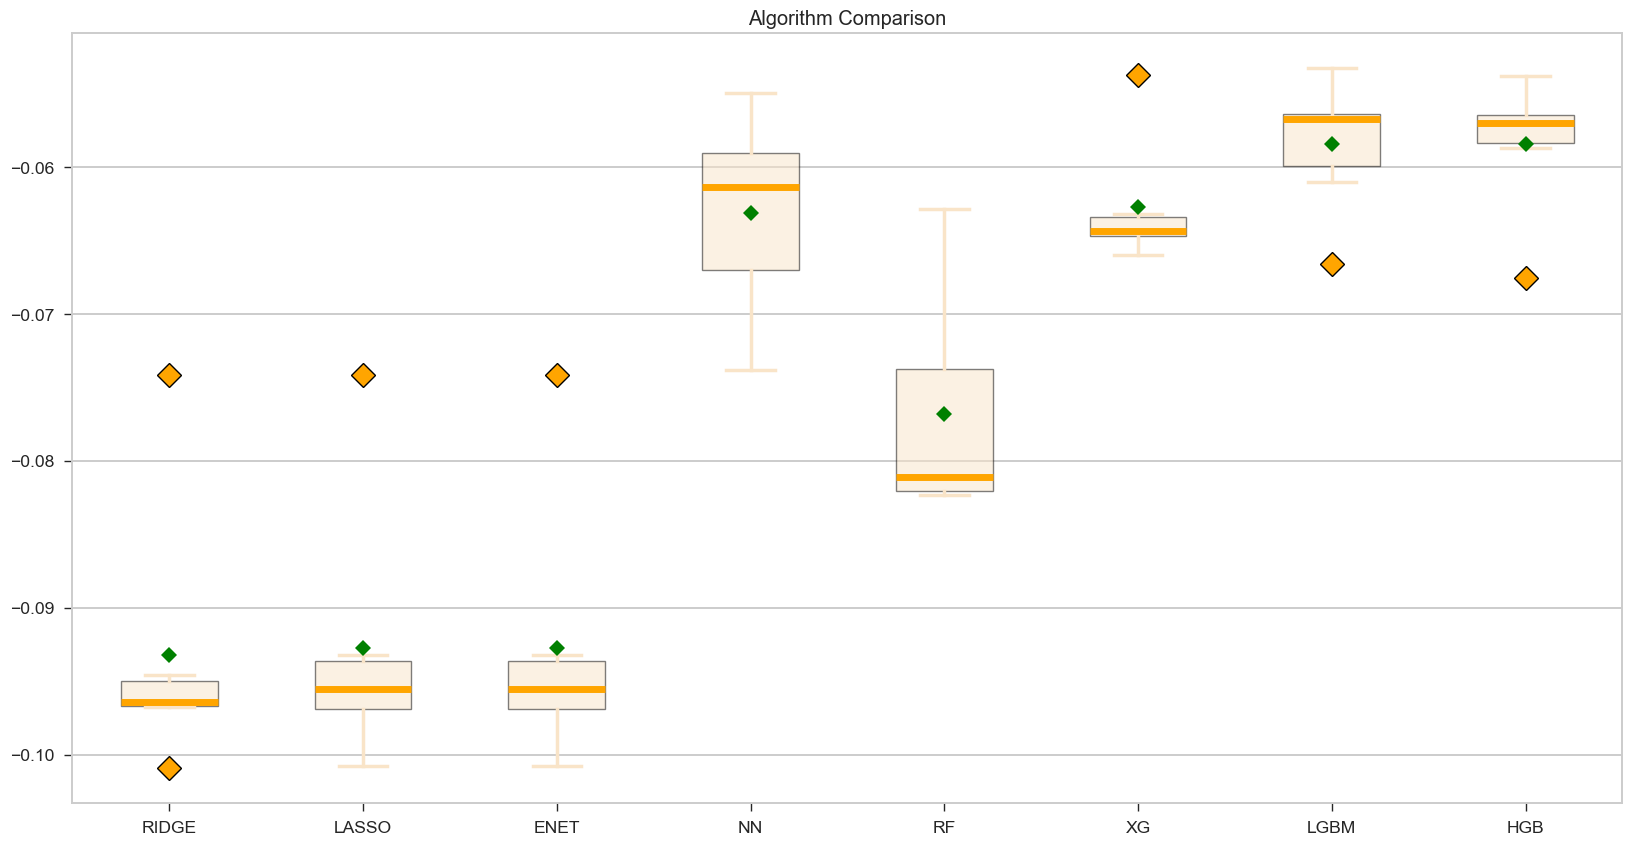

In [94]:
# Lower MAE
plot.plot_cross_val_scores(
    models=models,
    X=X,
    y=y,
    scaler=None,
    cv=tss,
    scoring="neg_mean_absolute_error",
)

RIDGE: 0.601190 (0.085044)
LASSO: 0.603184 (0.087896)
ENET: 0.603186 (0.087893)
NN: 0.808309 (0.043714)
RF: 0.733283 (0.056201)
XG: 0.814273 (0.048524)
LGBM: 0.823377 (0.058416)
HGB: 0.823732 (0.048395)


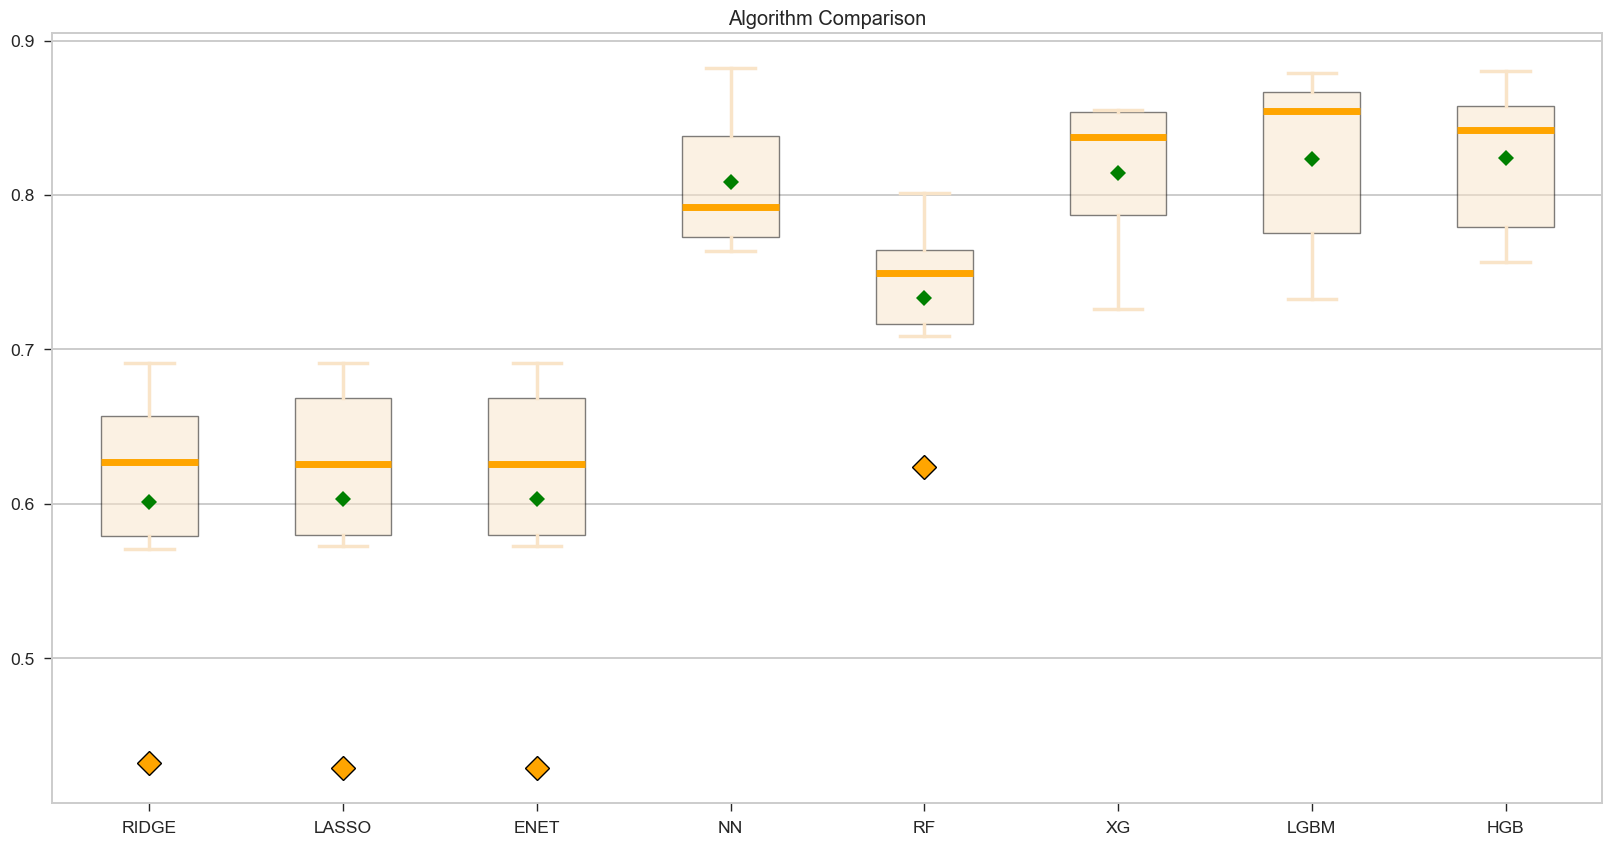

In [95]:
# Higher R²
plot.plot_cross_val_scores(
    models=models,
    X=X,
    y=y,
    scaler=None,
    cv=tss,
    scoring="r2",
)

## *Selecting the final model*
After evaluation with cross-validation, we observed that the HistGradientBoostingRegressor (HGB) demonstrated the optimal combination of high accuracy and low variability

- **MAE:** The HGB achieved a very low mean error (approximately 5.9%) with a standard deviation below 0.5%, indicating high precision and stability
- **R²:** The HGB reached an excellent value of 82.3%, demonstrating strong capability in capturing demand variability, with a standard deviation of 4.83%

Other models such as LGBM, XGBoost, and MLP (Neural Network) also showed good performance, but the HGB model outperformed them across all evaluation metrics, establishing itself as our champion model.

### *Training and evaluation of the final model*

- *Splitting data between train and test*

In [96]:
# Train-test split
train_size = int(len(X) * 0.75)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

### *Final Model Training and Evaluation*

- *Selected model: **HGB***

In [97]:
# =====================================================
# === FINAL MODEL TRAINING, PREDICTION & EVALUATION ===
# =====================================================

from scipy.stats import linregress

# Training the selected model (HGB)
# -----------------------------------------------------
# Using the chosen model from the configurations dictionary
final_model = model_configs["HGB"]
final_model.fit(X_train, y_train)

# Predict on both training and testing datasets
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)

In [98]:
# Performance evaluation
# -----------------------------------------------------
# Define a simple function to compute regression metrics
def regression_metrics(y_true, y_pred):
    """Compute common regression metrics: MAE, R², RMSE, and Bias."""
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    bias = np.mean(y_pred - y_true)
    return {"MAE": mae, "R²": r2, "RMSE": rmse, "Bias": bias}


# Compute metrics for both sets
results_train = regression_metrics(y_train, pred_train)
results_test = regression_metrics(y_test, pred_test)

# Combine results into a single DataFrame for comparison
results_df = pd.DataFrame({
    **{f"{k} - Train": v for k, v in results_train.items()},
    **{f"{k} - Test": v for k, v in results_test.items()},
}, index=[0])

# Display metrics
display(results_df)

,MAE - Train,R² - Train,RMSE - Train,Bias - Train,MAE - Test,R² - Test,RMSE - Test,Bias - Test
0,0.011206,0.988559,0.017787,-0.000024,0.066195,0.83166,0.099612,-0.029128


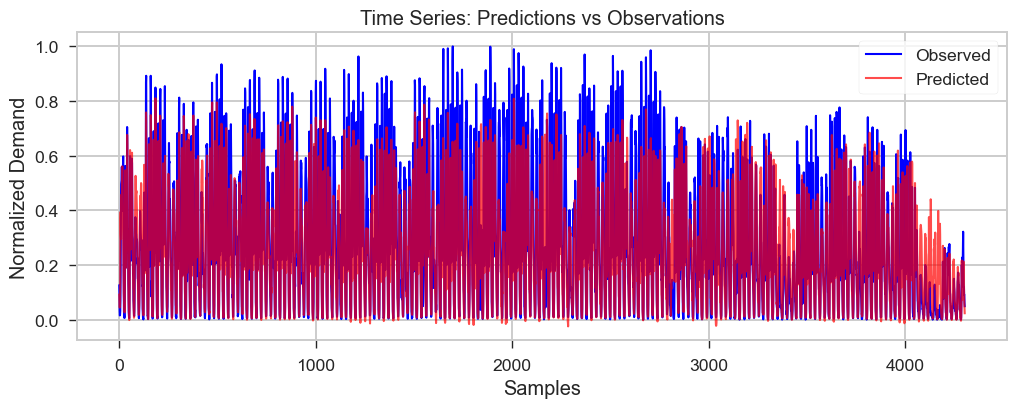

In [99]:
# Visualization 1: Time Series Comparison
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="Observed", color="blue")
plt.plot(pred_test, label="Predicted", color="red", alpha=0.7)
plt.xlabel("Samples")
plt.ylabel("Normalized Demand")
plt.title("Time Series: Predictions vs Observations")
plt.legend()
plt.grid(True)
plt.show()


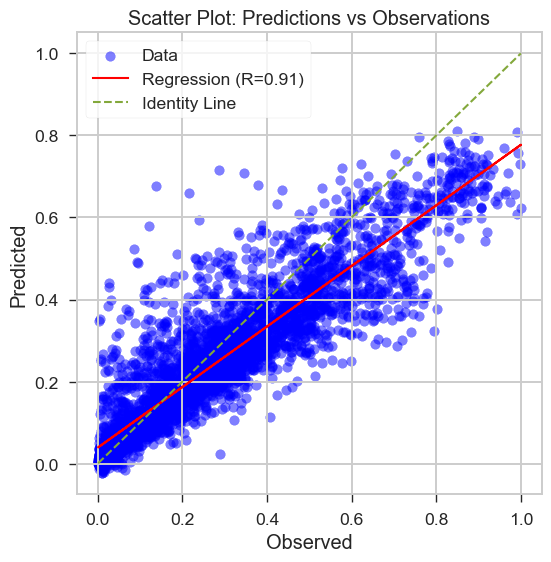

In [100]:
# Visualization 2: Scatter Plot with Regression Line
slope, intercept, r_value, p_value, std_err = linregress(y_test, pred_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_test, alpha=0.5, color="blue", label="Data")
plt.plot(y_test, slope * y_test + intercept, color="red",
         label=f"Regression (R={r_value:.2f})")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "g--", label="Identity Line")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot: Predictions vs Observations")
plt.legend()
plt.grid(True)
plt.show()


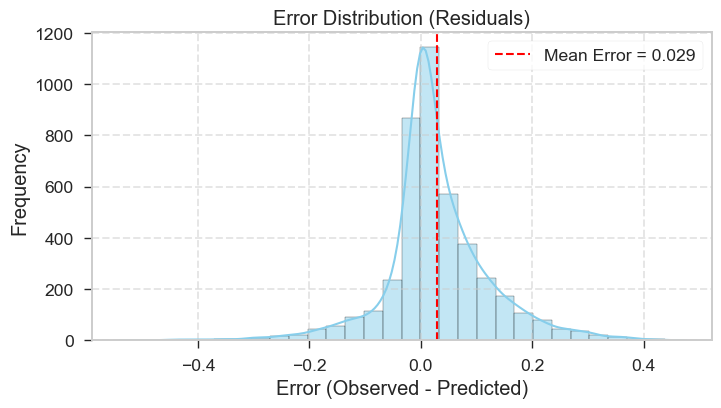

In [101]:
# Visualization 3: Error Distribution
residuals = y_test - pred_test

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor="black")

plt.title("Error Distribution (Residuals)")
plt.xlabel("Error (Observed - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axvline(residuals.mean(), color="red", linestyle="--",
            label=f"Mean Error = {residuals.mean():.3f}")
plt.legend()
plt.show()

In [102]:
# Retrain with full dataset (for deployment)
# -----------------------------------------------------
# X and y refer to the full dataset (feature-engineered data)
final_model.fit(X, y)
print("Final model trained successfully!")

Final model trained successfully!


### Overall Project Conclusions

- *The HistGradientBoostingRegressor (HGB) demonstrated excellent predictive performance, achieving strong generalization between training and testing datasets.*

- *High R²: 0.988 on training and 0.832 on testing, showing that the model captures most of the variability in bike demand while maintaining good generalization ability.*

- *Low error values (MAE and RMSE): with a MAE of 1.1% on training and 6.6% on testing, the model provides precise predictions even on unseen data.*

- *Minimal bias: near-zero bias values indicate that the model does not systematically overestimate or underestimate demand.*

- *A small underestimation bias on the test set (-0.029) can be fine-tuned later through calibration or bias correction techniques.*

### Error Distribution Analysis

- *The residuals (differences between observed and predicted values) are centered around zero and show limited dispersion.*

- *This indicates balanced and unbiased predictions, with no clear systematic pattern in the model’s errors.*

- *Small deviations during extreme conditions or specific time periods may later be addressed with contextual bias corrections (e.g., weather, holidays).*

### Overfitting and Underfitting Assessment

The comparison between training and testing metrics shows no clear signs of overfitting or underfitting:
- *The training R² (0.988) is only slightly higher than the testing R² (0.832) — a healthy difference that indicates good generalization without memorizing the training data.*

- *The moderate increase in MAE and RMSE from training to testing suggests that the model maintains consistent precision outside the training sample.*

- *The residual distribution supports this, as errors remain centered around zero and show no directional trend.*

Therefore, the HGB model generalizes well to unseen data, striking an excellent balance between complexity and accuracy.

### Future Improvements

- ***Hyperparameter optimization:** Implement GridSearchCV or Bayesian optimization to refine model parameters.*

- ***Continuous evaluation:** Monitor model performance in production and periodically retrain it to adapt to new demand patterns.*

### Practical Conclusions

#### The trained model is accurate and reliable enough for operational planning and bike fleet management.

#### The feature engineering process (cyclical encodings, lag and rolling features) successfully captured temporal patterns without requiring extensive hyperparameter tuning at this stage.

#### The model’s stability and interpretability make it a strong candidate for production use or integration with a real-time monitoring system.